In [458]:
import pandas as pd
import scanpy as sc
import seaborn as sns

In [459]:
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

In [501]:
adata = sc.read_h5ad(
    "/data/projects/2021/MicrobialMetabolites/single-cell-sorted-cd8/results/40_gex_surface_prot/13_january_2025/mapped_data/mapped_til_colon.h5ad"
)

In [502]:
adata.obs.cell_type = adata.obs.cell_type.replace("nan", "CD8_NaiveLike")

In [503]:
adata.obs.origin = adata.obs.origin.replace("colon", "normal")

In [504]:
adata.obs.origin = adata.obs.origin.replace("til", "tumor")

In [505]:
adata_normal = adata[adata.obs["origin"] == "normal"]

In [506]:
adata_tumor = adata[adata.obs["origin"] == "tumor"]

In [507]:
# Check if 'Ifng' is in the variable names
if "ENSMUSG00000055170" in adata.var_names:
    # Safely extract the expression values for 'Ifng'
    ifng_expression = (
        adata[:, "ENSMUSG00000055170"].X.toarray().flatten()
        if hasattr(adata[:, "ENSMUSG00000055170"].X, "toarray")
        else adata[:, "ENSMUSG00000055170"].X.flatten()
    )

    # Add Ifng expression status to adata.obs
    adata.obs["Ifng_expression"] = (ifng_expression > 6).astype(int)

    # Create a new column 'ifng' based on 'Ifng_expression'
    adata.obs["ifng"] = adata.obs["Ifng_expression"].apply(
        lambda x: "pos" if x == 1 else "neg"
    )
else:
    print("Gene 'Ifng' not found in adata.var_names")

In [467]:
adata.obs["Ifng_expression"].value_counts()

0    55719
1     4740
Name: Ifng_expression, dtype: int64

In [468]:
adata.obs.sample_id.value_counts()

10mix_ICI2      8133
10mix_ICI1      7153
GF_ICI2_plus    6855
11mix_ICI2      6768
11mix_ICI1      6496
GF_ICI1_plus    4754
GF_ICI1         4743
GF_ICI2         4408
11mix2          3196
11mix1          2266
10mix1          2206
10mix2          1618
GF1             1520
GF2              343
Name: sample_id, dtype: int64

In [469]:
adata.obs.origin.value_counts()

tumor     49310
normal    11149
Name: origin, dtype: int64

In [508]:
adata = adata[
    adata.obs["sample_id"].isin(
        [
            "10mix1",
            "10mix2",
            "11mix1",
            "11mix2",
            "10mix_ICI1",
            "10mix_ICI2",
            "11mix_ICI1",
            "11mix_ICI2",
        ]
    )
]

In [ ]:
# adata = adata[adata.obs["sample_id"].isin(["GF1","GF2","11mix1","11mix2","GF_ICI1","GF_ICI2","GF_ICI1_plus","GF_ICI2_plus"])]

In [ ]:
# adata_normal = adata[adata.obs['sample_id'].isin(["10mix1", "11mix1", "10mix2", "11mix2","GF1","GF2"])]
# adata_tumor = adata[adata.obs['sample_id'].isin(["10mix_ICI1", "11mix_ICI1", "10mix_ICI2", "11mix_ICI2","GF_ICI2_plus","GF_ICI1_plus","GF_ICI1","GF_ICI2"])]

In [413]:
adata.obs["cell_type_2"] = (
    adata.obs["cell_type"].astype(str) + "_" + adata.obs["origin"].astype(str)
)

/tmp/ipykernel_2985564/2680926087.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cell_type_2"] = (


In [414]:
adata.obs["cell_type_2"].value_counts()

CD8_Tex_tumor               13376
CD8_NaiveLike_tumor          9115
CD8_EffectorMemory_tumor     4736
CD8_NaiveLike_normal         3983
CD8_Tex_normal               3176
CD8_EarlyActiv_normal        2127
CD8_EarlyActiv_tumor          704
CD8_Tpex_tumor                619
Name: cell_type_2, dtype: int64

In [415]:
annotation_dict = {
    "CD8_Tex_tumor": "CD8_Tex_tumor",
    "CD8_NaiveLike_tumor": "CD8_NaiveLike_tumor",
    "CD8_EffectorMemory_tumor": "CD8_EffectorMemory_tumor",
    "CD8_NaiveLike_normal": "CD8_NaiveLike_normal",
    "CD8_Tex_normal": "CD8_EffectorMemory_normal",
    "CD8_EarlyActiv_normal": "CD8_EffectorMemory_normal",
    "CD8_EarlyActiv_tumor": "CD8_EarlyActiv_tumor",
    "CD8_Tpex_tumor": "CD8_Tpex_tumor",
}
## Add cell type column based on annotation
adata.obs["cell_type_2"] = [
    annotation_dict[clust] for clust in adata.obs["cell_type_2"]
]

In [ ]:
adata_normal.obs["cell_type"].value_counts()

In [ ]:
adata_tumor.obs["cell_type"].value_counts()

In [ ]:
adata.obs["sample_id"].value_counts()

In [ ]:
adata_normal.obs["sample_id"].value_counts()

In [ ]:
adata_tumor.obs["sample_id"].value_counts()

In [471]:
# Group by 'sample_id' and 'cell_type', and count the number of cells in each group
cell_counts = (
    adata.obs.groupby(["sample_id", "ifng", "cell_type", "condition"])
    .size()
    .reset_index(name="counts")
)

# Calculate the total number of cells per sample_id
total_counts_per_sample = cell_counts.groupby("sample_id")["counts"].transform("sum")

# Calculate the percentage of each cell type within each sample_id
cell_counts["percent"] = cell_counts["counts"] / total_counts_per_sample

# Convert to a DataFrame (if needed)
cell_counts_df = pd.DataFrame(cell_counts)

In [472]:
cell_counts_df

,sample_id,ifng,cell_type,condition,counts,percent
0,10mix1,neg,CD8_EarlyActiv,10mix,386,0.174977
1,10mix1,neg,CD8_EarlyActiv,11mix,0,0.000000
2,10mix1,neg,CD8_EffectorMemory,10mix,0,0.000000
3,10mix1,neg,CD8_EffectorMemory,11mix,0,0.000000
4,10mix1,neg,CD8_NaiveLike,10mix,1127,0.510879
...,...,...,...,...,...,...
155,11mix_ICI2,pos,CD8_NaiveLike,11mix,36,0.005319
156,11mix_ICI2,pos,CD8_Tex,10mix,0,0.000000
157,11mix_ICI2,pos,CD8_Tex,11mix,181,0.026743
158,11mix_ICI2,pos,CD8_Tpex,10mix,0,0.000000


In [473]:
data = cell_counts_df

In [474]:
data["cell_condition"] = (
    data["cell_type"].astype(str) + "_" + data["condition"].astype(str)
)

In [420]:
data["condition2"] = data["sample_id"].apply(
    lambda x: "10mix" if "10" in str(x) else ""
)

In [421]:
data["condition3"] = data["sample_id"].apply(
    lambda x: "11mix" if "11" in str(x) else ""
)

In [422]:
data["condition"] = (
    data["condition1"].astype("str")
    + data["condition2"].astype("str")
    + data["condition3"].astype("str")
)

In [475]:
data

,sample_id,ifng,cell_type,condition,counts,percent,cell_condition
0,10mix1,neg,CD8_EarlyActiv,10mix,386,0.174977,CD8_EarlyActiv_10mix
1,10mix1,neg,CD8_EarlyActiv,11mix,0,0.000000,CD8_EarlyActiv_11mix
2,10mix1,neg,CD8_EffectorMemory,10mix,0,0.000000,CD8_EffectorMemory_10mix
3,10mix1,neg,CD8_EffectorMemory,11mix,0,0.000000,CD8_EffectorMemory_11mix
4,10mix1,neg,CD8_NaiveLike,10mix,1127,0.510879,CD8_NaiveLike_10mix
...,...,...,...,...,...,...,...
155,11mix_ICI2,pos,CD8_NaiveLike,11mix,36,0.005319,CD8_NaiveLike_11mix
156,11mix_ICI2,pos,CD8_Tex,10mix,0,0.000000,CD8_Tex_10mix
157,11mix_ICI2,pos,CD8_Tex,11mix,181,0.026743,CD8_Tex_11mix
158,11mix_ICI2,pos,CD8_Tpex,10mix,0,0.000000,CD8_Tpex_10mix


In [509]:
x = "cell_condition"
y = "percent"
hue = "condition"

In [510]:
data = cell_counts_df[
    ["undefined" not in x for x in cell_counts_df.sample_id]
    & (cell_counts_df["ifng"] == "pos")
]
data.sort_values(by="sample_id", inplace=True)

/tmp/ipykernel_2985564/779750287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by="sample_id", inplace=True)


In [511]:
data

,sample_id,ifng,cell_type,condition,counts,percent,cell_condition
10,10mix1,pos,CD8_EarlyActiv,10mix,158,0.071623,CD8_EarlyActiv_10mix
11,10mix1,pos,CD8_EarlyActiv,11mix,0,0.000000,CD8_EarlyActiv_11mix
12,10mix1,pos,CD8_EffectorMemory,10mix,0,0.000000,CD8_EffectorMemory_10mix
13,10mix1,pos,CD8_EffectorMemory,11mix,0,0.000000,CD8_EffectorMemory_11mix
14,10mix1,pos,CD8_NaiveLike,10mix,41,0.018586,CD8_NaiveLike_10mix
...,...,...,...,...,...,...,...
154,11mix_ICI2,pos,CD8_NaiveLike,10mix,0,0.000000,CD8_NaiveLike_10mix
155,11mix_ICI2,pos,CD8_NaiveLike,11mix,36,0.005319,CD8_NaiveLike_11mix
156,11mix_ICI2,pos,CD8_Tex,10mix,0,0.000000,CD8_Tex_10mix
157,11mix_ICI2,pos,CD8_Tex,11mix,181,0.026743,CD8_Tex_11mix


In [ ]:
# specific_order = ["GF", "10mix", "11mix"]  # Replace with your desired order
data["condition"] = pd.Categorical(
    data["condition"], categories=specific_order, ordered=True
)

In [483]:
add_stat_annotation(
    g,
    data=data,
    x=x,
    y=y,
    box_pairs=[("10mix", "11mix")],
    test="Mann-Whitney",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)

ValueError: box_pairs contains an invalid box pair.

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, '')

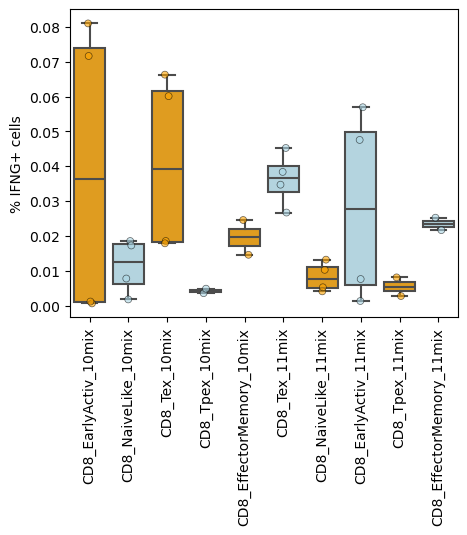

In [484]:
g = sns.boxplot(y=y, x=x, data=data, palette=["orange", "lightblue"])  # kind="box",
sns.stripplot(
    y=y,
    x=x,
    data=data,
    palette=["orange", "lightblue"],
    dodge=True,
    alpha=0.6,
    edgecolor="black",
    linewidth=0.5,
)


g.figure.set_figwidth(5)
g.figure.set_figheight(4)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_ylabel("% IFNG+ cells")
g.set_xlabel("")

In [ ]:
x = "condition"
y = "percent"
hue = "condition"

In [ ]:
g = sns.boxplot(y=y, x=x, data=data, palette=["orange", "lightblue"])  # kind="box",
sns.stripplot(
    y=y,
    x=x,
    data=data,
    palette=["orange", "lightblue"],
    dodge=True,
    alpha=0.6,
    edgecolor="black",
    linewidth=0.5,
)

add_stat_annotation(
    g,
    data=data,
    x=x,
    y=y,
    box_pairs=[
        ("10mix", "11mix"),
    ],
    test="Mann-Whitney",
    text_format="simple",
    loc="inside",
    verbose=0,
)  # , comparisons_correction='bonferroni')


g.figure.set_figwidth(5)
g.figure.set_figheight(4)
g.set_title("Tumor: Condition differences")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_ylabel("Percent Ifng+ cells")
g.set_xlabel("")

In [ ]:
x = "sample_id"
y = "percent"
hue = "sample_id"

In [ ]:
g = sns.boxplot(y=y, x=x, data=data, palette=["orange", "lightblue"])  # kind="box",
sns.stripplot(
    y=y,
    x=x,
    data=data,
    palette=["orange", "lightblue"],
    dodge=True,
    alpha=0.6,
    edgecolor="black",
    linewidth=0.5,
)


g.figure.set_figwidth(5)
g.figure.set_figheight(4)
g.set_title("Tumor: Sample differences")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_ylabel("Percent Ifng+ cells")
g.set_xlabel("")

In [ ]:
import matplotlib.pyplot as plt


# Define a function to extract Ifng expression levels for a given dataset
def extract_ifng_expression(adata, gene="ENSMUSG00000055170", threshold=0):
    if gene in adata.var_names:
        ifng_expression = (
            adata[:, gene].X.toarray().flatten()
            if hasattr(adata[:, gene].X, "toarray")
            else adata[:, gene].X.flatten()
        )
        # Filter cells that express Ifng based on the threshold
        return (
            ifng_expression[ifng_expression > threshold],
            adata.obs["condition"][ifng_expression > threshold],
        )
    else:
        return None, None


# Extract Ifng expression levels and conditions for each dataset
ifng_expression_adata, condition_adata = extract_ifng_expression(adata)
ifng_expression_normal, condition_normal = extract_ifng_expression(
    adata[adata.obs["sample_id"].isin(["10mix1", "11mix1", "10mix2", "11mix2"])]
)
ifng_expression_tumor, condition_tumor = extract_ifng_expression(
    adata[
        adata.obs["sample_id"].isin(
            ["10mix_ICI1", "11mix_ICI1", "10mix_ICI2", "11mix_ICI2"]
        )
    ]
)

# Create a figure with 3 subplots
plt.figure(figsize=(18, 6))

# Plot histogram for adata, colored by condition
plt.subplot(1, 3, 1)
plt.hist(
    ifng_expression_adata[condition_adata == "10mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="10mix",
    color="blue",
)
plt.hist(
    ifng_expression_adata[condition_adata == "11mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="11mix",
    color="orange",
)
plt.title("Ifng Expression (Tumor & Normal)")
plt.xlabel("Ifng Expression Level")
plt.ylabel("Number of Cells")
plt.legend(title="Condition")

# Plot histogram for adata_normal, colored by condition
plt.subplot(1, 3, 2)
plt.hist(
    ifng_expression_normal[condition_normal == "10mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="10mix",
    color="blue",
)
plt.hist(
    ifng_expression_normal[condition_normal == "11mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="11mix",
    color="orange",
)
plt.title("Ifng Expression (Normal)")
plt.xlabel("Ifng Expression Level")
plt.ylabel("Number of Cells")
plt.legend(title="Condition")

# Plot histogram for adata_tumor, colored by condition
plt.subplot(1, 3, 3)
plt.hist(
    ifng_expression_tumor[condition_tumor == "10mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="10mix",
    color="blue",
)
plt.hist(
    ifng_expression_tumor[condition_tumor == "11mix"],
    bins=30,
    edgecolor="black",
    alpha=0.7,
    label="11mix",
    color="orange",
)
plt.title("Ifng Expression (Tumor)")
plt.xlabel("Ifng Expression Level")
plt.ylabel("Number of Cells")
plt.legend(title="Condition")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
adata.obs

In [ ]:
### annotation

In [ ]:
marker_dict_small = {
    "CD8_NaiveLike": [
        "Ccr7",
        "Il7r",
        "Sell",
        "Tcf7",
        "Txk",
        "S1pr1",
        "Lef1",
        "Satb1",
    ],
    "CD8_EarlyActiv": ["Fosb", "Gzmm", "Samd3", "Cxcr4", "Btg2"],
    "CD8_EffectorMemory": [
        "Gzma",
        "Gzmk",
        "Gzmb",
        "Ccl5",
    ],
    "CD8_Tpex": [
        "Xcl1",
        "Crtam",
        "Ifng",
        "Ccl4",
        "Dusp4",
        "Zeb2",
        "Nr4a2",
        "Sla",
    ],
    "CD8_Tex": [
        "Pdcd1",
        "Prf1",
        "Havcr2",
    ],
}

In [ ]:
marker_dict_small_normal = {
    "CD8_NaiveLike": [
        "Ccr7",
        "Il7r",
        "Sell",
        "Tcf7",
        "Txk",
        "S1pr1",
        "Lef1",
        "Satb1",
    ],
    "CD8_EarlyActiv": ["Fosb", "Gzmm", "Samd3", "Cxcr4", "Btg2"],
    "CD8_Tex": [
        "Pdcd1",
        "Prf1",
        "Havcr2",
        "Nkg7",
        "Cd8b1",
        "Ctsd",
    ],
}

In [ ]:
adata.obs.cell_type_2.value_counts()

In [ ]:
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike_normal",
    "CD8_EarlyActiv_normal",
    "CD8_Tex_normal",
    "CD8_NaiveLike_tumor",
    "CD8_EarlyActiv_tumor",
    "CD8_EffectorMemory_tumor",
    "CD8_Tpex_tumor",
    "CD8_Tex_tumor",
]

# Reorder the categories in adata.obs['leiden_res0_25']
adata.obs["cell_type_2"] = pd.Categorical(
    adata.obs["cell_type_2"], categories=desired_order, ordered=True
)

In [ ]:
sc.pl.dotplot(
    adata,
    marker_dict_small,
    groupby="cell_type_2",
    gene_symbols="gene_name",
    dendrogram=False,
    standard_scale="var",
    cmap="viridis",
)  # , save ="mapped_annotation_tumor_normal.svg")

In [ ]:
sc.pl.matrixplot(
    adata,
    marker_dict_small,
    groupby="cell_type",
    gene_symbols="gene_name",
    dendrogram=False,
    standard_scale="var",
    cmap="viridis",
)  # , save ="mapped_annotation_tumor_normal.svg")

In [ ]:
sc.pl.matrixplot(
    adata,
    marker_dict_small,
    groupby="cell_type",
    gene_symbols="gene_name",
    dendrogram=False,
    standard_scale="var",
    cmap="viridis",
)  # , save ="mapped_annotation_tumor_normal.svg")

In [ ]:
# Specify the desired order of the categories
desired_order = ["CD8_NaiveLike", "CD8_EarlyActiv", "CD8_Tex"]

# Reorder the categories in adata.obs['leiden_res0_25']
adata_normal.obs["cell_type"] = pd.Categorical(
    adata_normal.obs["cell_type"], categories=desired_order, ordered=True
)

In [ ]:
sc.pl.dotplot(
    adata_normal,
    marker_dict_small_normal,
    groupby="cell_type",
    gene_symbols="gene_name",
    dendrogram=False,
    standard_scale="var",
    cmap="viridis",
)  # , save ="mapped_annotation_tumor_normal.svg")

In [ ]:
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]

# Reorder the categories in adata.obs['leiden_res0_25']
adata_tumor.obs["cell_type"] = pd.Categorical(
    adata_tumor.obs["cell_type"], categories=desired_order, ordered=True
)

In [ ]:
sc.pl.matrixplot(
    adata,
    marker_dict_small,
    groupby="cell_type_2",
    gene_symbols="gene_name",
    dendrogram=False,
    standard_scale="var",
    cmap="viridis",
)  # , save ="mapped_annotation_tumor_normal.svg")

In [ ]:
sc.pl.matrixplot(
    adata, "Ifng", groupby="condition", gene_symbols="gene_name", cmap="viridis"
)  # , save ="mapped_annotation_tumor_normal.svg")

In [ ]:
sc.pl.umap(adata, color="cell_type_2")

In [ ]:
adata.obs.cell_type.value_counts()

In [ ]:
adata.obs.leiden_res0_5.value_counts()

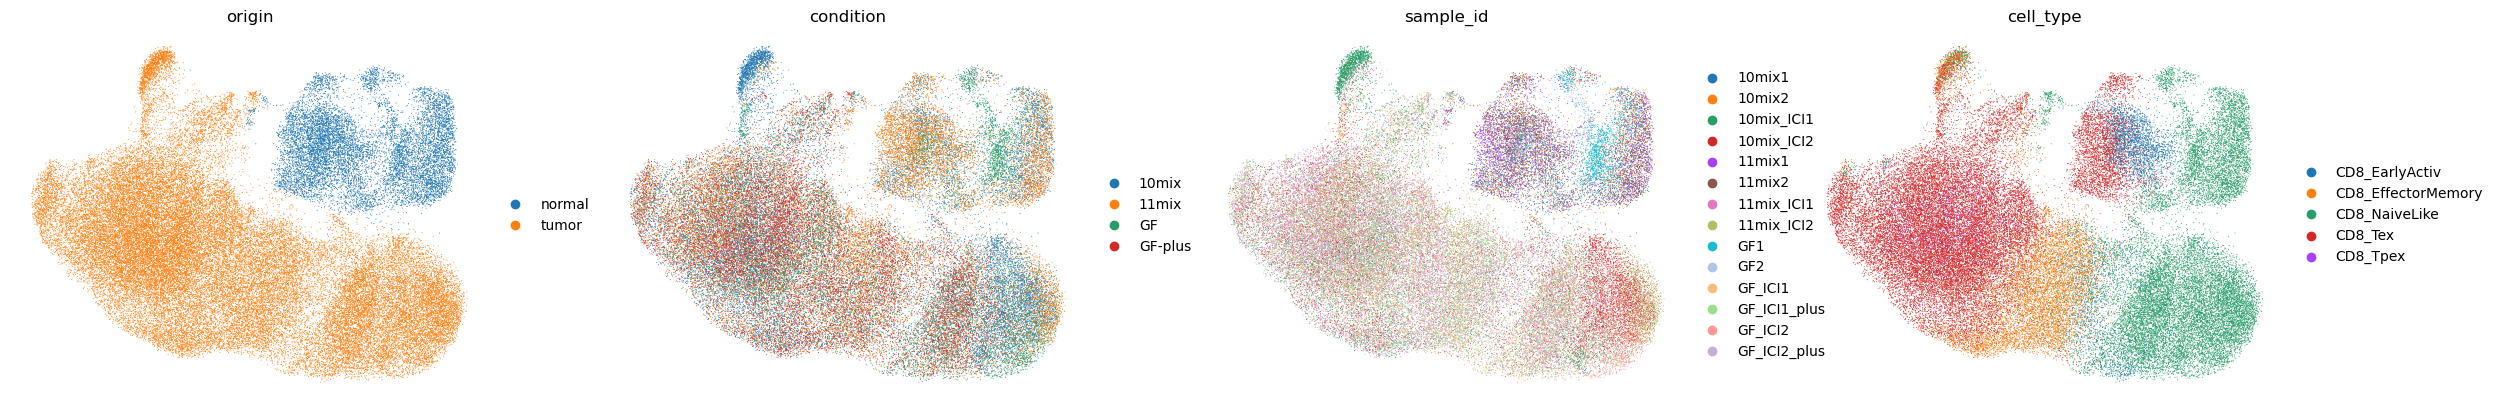

In [15]:
sc.pl.umap(
    adata,
    color=["origin", "condition", "sample_id", "cell_type"],
    frameon=False,
    save="_all.pdf",
)

In [ ]:
sc.pl.umap(adata, color=["leiden"], groups=["2"])

In [ ]:
annotation_dict = {
    "0": "CD8_Tex_Tumor",
    "1": "CD8_EffectorMemory_Tumor",
    "2": "",
    "3": "",
    "4": "",
    "5": "",
    "6": "",
    "7": "",
    "8": "",
    "9": "",
    "10": "",
    "11": "",
    "12": "",
    "13": "",
    "14": "",
}
## Add cell type column based on annotation
adata.obs["cell_type_2"] = [annotation_dict[clust] for clust in adata.obs["leiden"]]

In [ ]:
marker_dict = {
    "CD8_NaiveLike": [
        "Ccr7",
        "Il7r",
        "Sell",
        "Tcf7",
        "Txk",
        "S1pr1",
        "Lef1",
        "Satb1",
    ],
    "CD8_EarlyActiv": [
        "Gzmk",
        "Fos",
        "Cd69",
        "Zfp36",
        "Fosb",
        "Ccl5",
        "Gzmm",
        "Dusp2",
        "Lyar",
        "Samd3",
        "Cxcr4",
        "Ctsw",
        "Cd8a",
        "Anxa1",
        "Klrg1",
        "Cd8b1",
        "Aoah",
        "Tagap",
        "Klrd1",
        "Ier2",
        "Gzma",
        "Cst7",
        "Itm2c",
        "Parp8",
        "Btg2",
    ],
    "CD8_EffectorMemory": [
        "Gzma",
        "Gzmk",
        "Nkg7",
        "Cd8a",
        "Cd8b1",
        "Ctsw",
        "Gzmb",
        "Ccl5",
        "Cst7",
        "Prf1",
        "Abi3",
        "Fasl",
        "Itm2c",
        "1500009L16Rik",
        "Eomes",
        "Chst12",
        "Ccr5",
        "Hcst",
        "Aoah",
        "Hopx",
        "Slamf7",
        "Cxcr3",
        "Oasl1",
        "F2r",
        "Cxcr6",
    ],
    "CD8_Tpex": [
        "Lag3",
        "Xcl1",
        "Crtam",
        "Ifng",
        "Ccl4",
        "Pdcd1",
        "Dusp4",
        "Cd8a",
        "Zeb2",
        "Nr4a2",
        "Sla",
        "Nkg7",
        "Tigit",
        "Ctsw",
        "Tnfrsf9",
        "Tox",
        "Lyst",
        "Tnfsf4",
        "Ccl3",
        "Gzmb",
        "Rab27a",
        "Prf1",
        "Cd70",
        "Plscr1",
    ],
    "CD8_Tex": [
        "Lag3",
        "Prf1",
        "Cd8a",
        "Havcr2",
        "Gzmb",
        "Nkg7",
        "Cd8b1",
        "Ctsd",
        "Klrd1",
        "Id2",
        "Cst7",
        "Pdcd1",
        "Tnfrsf9",
        "Tigit",
        "Ctsw",
        "Ccl4",
        "Ccl3",
        "Ifng",
        "Cxcr6",
        "Fasl",
        "Rbpj",
        "Chst12",
        "Fam3c",
        "Csf1",
    ],
}

In [ ]:
sc.pl.clustermap(adata_tumor)

In [ ]:
u = sns.FacetGrid(
    adata.obs,
    col="ifng",
    hue="cell_type",
    sharey=False,
    sharex=True,
    height=2,
    aspect=2,
    margin_titles=True,
    col_wrap=4,
)
u.map_dataframe(sns.histplot, x="cell_type", common_norm=True, stat="count")
u.set_xticklabels(rotation="vertical")

In [ ]:
sc.pp.highly_variable_genes(adata, min_disp=0.1, min_mean=0.01, max_mean=50)

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.var["variance"] = adata.to_df().var()

In [ ]:
adata.var["variance"]

In [ ]:
adata.var

In [ ]:
sns.scatterplot(data=adata.var, x="means", y="variance")

In [ ]:
f = sns.pointplot(
    data=adata[:, adata.var.variance > 0.1].var,
    y="gene_name",
    x="variance",
    color="orange",
    order=["Cxcr6", "Chst12", "Fam3c", "Csf1"],
)
# f.figure.savefig(resultsDir+"/variance_genes_CD8_MSI.png",  bbox_inches='tight')

In [ ]:
adata.var

In [ ]:
sc.pl.highest_expr_genes(
    adata, gene_symbols="gene_name"
)  # , save="boxplot_CD8_NormMSI.png")

In [ ]:
sc.pl.highest_expr_genes(
    adata_tumor, gene_symbols="gene_name"
)  # , save="boxplot_CD8_NormMSI.png")

In [ ]:
sc.pl.highest_expr_genes(
    adata_normal, gene_symbols="gene_name"
)  # , save="boxplot_CD8_NormMSI.png")

In [ ]:
adata.obs

In [ ]:
adata.to_df()

In [ ]:
f = sns.kdeplot(
    data=adata.to_df(),
    x="ENSMUSG00000055170",
    common_norm=False,
    color="tab:orange",
    linestyle=":",
)
sns.kdeplot(
    data=adata_tumor.to_df(),
    x="ENSMUSG00000055170",
    common_norm=False,
    color="tab:blue",
    linestyle=":",
)
sns.kdeplot(
    data=adata_normal.to_df(),
    x="ENSMUSG00000055170",
    common_norm=False,
    color="tab:orange",
)
f.axvline(x=0.2, color="black", linestyle=":")
f.grid(False)
# f.figure.savefig(resultsDir+"/kdeplot_CD8_IFNGdist_BOTHmsimsswithNorm.png")
# f.figure.savefig(resultsDir+"/kdeplot_CD8_IFNGdist_BOTHmsimsswithNorm.svg")

In [ ]:
f = sns.kdeplot(
    data=adata.to_df(),
    x="ENSMUSG00000055170",
    common_norm=False,
    color="tab:orange",
    linestyle=":",
)
sns.kdeplot(
    data=adata_tumor.to_df(),
    x="ENSMUSG00000055170",
    common_norm=False,
    color="tab:blue",
    linestyle=":",
)
sns.kdeplot(
    data=adata_normal.to_df(),
    x="ENSMUSG00000055170",
    common_norm=False,
    color="tab:orange",
)
f.axvline(x=0.2, color="black", linestyle=":")
f.grid(False)
# f.figure.savefig(resultsDir+"/kdeplot_CD8_IFNGdist_BOTHmsimsswithNorm.png")
# f.figure.savefig(resultsDir+"/kdeplot_CD8_IFNGdist_BOTHmsimsswithNorm.svg")

In [ ]:
sc.pl.clustermap(adata)

In [ ]:
## fraction of cells

In [512]:
data

,sample_id,ifng,cell_type,condition,counts,percent,cell_condition
10,10mix1,pos,CD8_EarlyActiv,10mix,158,0.071623,CD8_EarlyActiv_10mix
11,10mix1,pos,CD8_EarlyActiv,11mix,0,0.000000,CD8_EarlyActiv_11mix
12,10mix1,pos,CD8_EffectorMemory,10mix,0,0.000000,CD8_EffectorMemory_10mix
13,10mix1,pos,CD8_EffectorMemory,11mix,0,0.000000,CD8_EffectorMemory_11mix
14,10mix1,pos,CD8_NaiveLike,10mix,41,0.018586,CD8_NaiveLike_10mix
...,...,...,...,...,...,...,...
154,11mix_ICI2,pos,CD8_NaiveLike,10mix,0,0.000000,CD8_NaiveLike_10mix
155,11mix_ICI2,pos,CD8_NaiveLike,11mix,36,0.005319,CD8_NaiveLike_11mix
156,11mix_ICI2,pos,CD8_Tex,10mix,0,0.000000,CD8_Tex_10mix
157,11mix_ICI2,pos,CD8_Tex,11mix,181,0.026743,CD8_Tex_11mix


In [513]:
adata_10 = adata[
    adata.obs["sample_id"].isin(["10mix1", "10mix2", "10mix_ICI1", "10mix_ICI2"])
]

In [514]:
adata_11 = adata[
    adata.obs["sample_id"].isin(["11mix1", "11mix2", "11mix_ICI1", "11mix_ICI2"])
]

In [515]:
test = pd.DataFrame(adata_10.obs.value_counts(subset=["cell_type", "sample_id"]))
testp = adata_10.obs.value_counts(subset=["sample_id"])
test.columns = ["counts"]
test["percent"] = test.counts
for p in set(adata_10.obs.sample_id):
    test.loc[test.index.get_level_values("sample_id") == p, "percent"] = (
        test.loc[test.index.get_level_values("sample_id") == p, "percent"] / testp[p]
    )
test["percent"] = [float(x) for x in test["percent"]]
test["sample_id"] = [str(x) for x in test.index.get_level_values("sample_id")]
test["cell_type"] = [str(x) for x in test.index.get_level_values("cell_type")]
# test["IFNG+"]=[str(x) for x in test.index.get_level_values("IFNG_0.2")]
test["status"] = "10mix"

In [516]:
patientProps = test

In [517]:
test = pd.DataFrame(adata_11.obs.value_counts(subset=["cell_type", "sample_id"]))
testp = adata_11.obs.value_counts(subset=["sample_id"])
test.columns = ["counts"]
test["percent"] = test.counts
for p in set(adata_11.obs.sample_id):
    test.loc[test.index.get_level_values("sample_id") == p, "percent"] = (
        test.loc[test.index.get_level_values("sample_id") == p, "percent"] / testp[p]
    )
test["percent"] = [float(x) for x in test["percent"]]
test["sample_id"] = [str(x) for x in test.index.get_level_values("sample_id")]
test["cell_type"] = [str(x) for x in test.index.get_level_values("cell_type")]
# test["IFNG+"]=[str(x) for x in test.index.get_level_values("IFNG_0.2")]
test["status"] = "11mix"

In [518]:
patientProps

counts   percent   sample_id  \
cell_type          sample_id                                  
CD8_Tex            10mix_ICI1    3980  0.556410  10mix_ICI1   
CD8_NaiveLike      10mix_ICI2    3856  0.474118  10mix_ICI2   
CD8_Tex            10mix_ICI2    3297  0.405385  10mix_ICI2   
CD8_NaiveLike      10mix_ICI1    1631  0.228016  10mix_ICI1   
CD8_EffectorMemory 10mix_ICI1    1331  0.186076  10mix_ICI1   
CD8_NaiveLike      10mix1        1168  0.529465      10mix1   
                   10mix2         827  0.511125      10mix2   
CD8_EffectorMemory 10mix_ICI2     704  0.086561  10mix_ICI2   
CD8_EarlyActiv     10mix1         544  0.246600      10mix1   
CD8_Tex            10mix1         494  0.223935      10mix1   
CD8_EarlyActiv     10mix2         459  0.283684      10mix2   
CD8_Tex            10mix2         332  0.205192      10mix2   
CD8_Tpex           10mix_ICI2     163  0.020042  10mix_ICI2   
CD8_EarlyActiv     10mix_ICI2     113  0.013894  10mix_ICI2   
CD8_Tpex           10mix_ICI1     110  0.015378  10mix_ICI1   
CD8_EarlyActiv     10mix_ICI1     101  0.014120  10mix_ICI1   

                                        cell_type status  
cell_type          sample_id                              
CD8_Tex            10mix_ICI1             CD8_Tex  10mix  
CD8_NaiveLike      10mix_ICI2       CD8_NaiveLike  10mix  
CD8_Tex            10mix_ICI2             CD8_Tex  10mix  
CD8_NaiveLike      10mix_ICI1       CD8_NaiveLike  10mix  
CD8_EffectorMemory 10mix_ICI1  CD8_EffectorMemory  10mix  
CD8_NaiveLike      10mix1           CD8_NaiveLike  10mix  
                   10mix2           CD8_NaiveLike  10mix  
CD8_EffectorMemory 10mix_ICI2  CD8_EffectorMemory  10mix  
CD8_EarlyActiv     10mix1          CD8_EarlyActiv  10mix  
CD8_Tex            10mix1                 CD8_Tex  10mix  
CD8_EarlyActiv     10mix2          CD8_EarlyActiv  10mix  
CD8_Tex            10mix2                 CD8_Tex  10mix  
CD8_Tpex           10mix_ICI2            CD8_Tpex  10mix  
CD8_EarlyActiv     10mix_ICI2      CD8_EarlyActiv  10mix  
CD8_Tpex           10mix_ICI1            CD8_Tpex  10mix  
CD8_EarlyActiv     10mix_ICI1      CD8_EarlyActiv  10mix

In [519]:
patientProps = pd.concat([patientProps, test], ignore_index=True, axis=0, join="outer")
patientProps["statuscell_type"] = patientProps.status + "_" + patientProps.cell_type
patientProps["samplelabels"] = patientProps.status + "_" + patientProps.sample_id
# patientProps["IFNG+"].replace(to_replace="True", value="Pos", inplace=True)
# patientProps["IFNG+"].replace(to_replace="False", value="Neg", inplace=True)
# patientProps["x"]="x"

In [520]:
# hueord=['CD4_MSI','CD4_MSS','CD8_MSI','CD8_MSS','undefined_MSI','undefined_MSS','CD4_NormMSI','CD4_NormMSS','CD8_NormMSI','CD8_NormMSS','undefined_NormMSI','undefined_NormMSS']
x = "cell_type"
y = "percent"
hue = "status"
data = patientProps

In [521]:
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
# Reorder the categories in adata.obs['leiden_res0_25']
data["cell_type"] = pd.Categorical(
    data["cell_type"], categories=desired_order, ordered=True
)

In [522]:
import matplotlib as plt

In [542]:
box_pairs = [
   # (("CD8_NaiveLike", "10mix"), ("CD8_NaiveLike", "11mix")),
    #(("CD8_EarlyActiv", "10mix"), ("CD8_EarlyActiv", "11mix")),
  # (("CD8_EffectorMemory", "10mix"), ("CD8_EffectorMemory", "11mix")),
    #(("CD8_Tpex", "10mix"), ("CD8_Tpex", "11mix")),  
    (("CD8_Tex", "10mix"), ("CD8_Tex", "11mix")),
]

In [563]:
data

,counts,percent,sample_id,cell_type,status,statuscell_type,samplelabels
0,3980,0.556410,10mix_ICI1,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix_ICI1
1,3856,0.474118,10mix_ICI2,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix_ICI2
2,3297,0.405385,10mix_ICI2,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix_ICI2
3,1631,0.228016,10mix_ICI1,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix_ICI1
4,1331,0.186076,10mix_ICI1,CD8_EffectorMemory,10mix,10mix_CD8_EffectorMemory,10mix_10mix_ICI1
5,1168,0.529465,10mix1,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix1
6,827,0.511125,10mix2,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix2
7,704,0.086561,10mix_ICI2,CD8_EffectorMemory,10mix,10mix_CD8_EffectorMemory,10mix_10mix_ICI2
8,544,0.246600,10mix1,CD8_EarlyActiv,10mix,10mix_CD8_EarlyActiv,10mix_10mix1
9,494,0.223935,10mix1,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix1


Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt
Using zero_method  pratt


Text(25.09722222222222, 0.5, 'Fraction of Ifng+ CD8 T cellls (% of total')

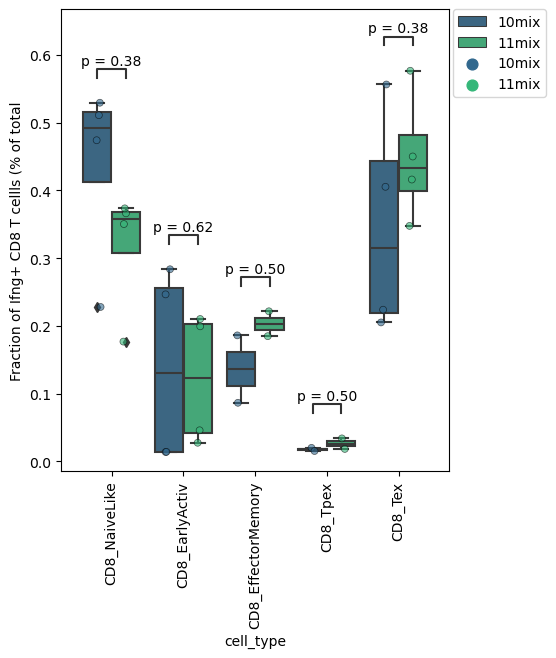

In [569]:
f = sns.boxplot(y=y, x=x, data=data, hue=hue, palette="viridis")
f.set_xticklabels(f.get_xticklabels(), rotation="vertical")
f.figure.set_size_inches(5, 6)
sns.stripplot(y=y, hue=hue, x=x,  data=data,palette="viridis", dodge=True, alpha=0.6, edgecolor="black", linewidth=0.5)
plt.pyplot.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0)
add_stat_annotation(
    f,
    data=data,
    x=x,
    y=y,
    hue=hue,
 box_pairs=[(("CD8_NaiveLike", "10mix"), ("CD8_NaiveLike", "11mix"))
],
    test="Wilcoxon",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)
add_stat_annotation(
    f,
    data=data,
    x=x,
    y=y,
    hue=hue,
 box_pairs=[(("CD8_EarlyActiv", "10mix"), ("CD8_EarlyActiv", "11mix")),
],
    test="Wilcoxon",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)
add_stat_annotation(
    f,
    data=data,
    x=x,
    y=y,
    hue=hue,
 box_pairs=[(("CD8_EffectorMemory", "10mix"), ("CD8_EffectorMemory", "11mix")),
],
    test="Wilcoxon",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)

add_stat_annotation(
    f,
    data=data,
    x=x,
    y=y,
    hue=hue,
 box_pairs=[(("CD8_Tpex", "10mix"), ("CD8_Tpex", "11mix"))
],
    test="Wilcoxon",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)
add_stat_annotation(
    f,
    data=data,
    x=x,
    y=y,
    hue=hue,
 box_pairs=[(("CD8_Tex", "10mix"), ("CD8_Tex", "11mix")),
],
    test="Wilcoxon",
    text_format="simple",
    loc="inside",
    verbose=0,
    comparisons_correction="bonferroni",
)
f.set_ylabel("Fraction of Ifng+ CD8 T cellls (% of total")



In [574]:
import scipy.stats as stats
from scipy.stats import ttest_rel
import numpy as np

before = np.array([0.556410, 0.405385, 0.223935,0.205192])
after = np.array([0.576663,0.347665 ,0.416145 ,0.450132])

t_stat, p_value = ttest_rel(before, after)

# Cohen’s d for paired samples
effect_size = (np.mean(after - before)) / np.std(after - before, ddof=1)

print(f"T-statistic: {t_stat}, P-value: {p_value}, Effect Size (Cohen's d): {effect_size}")

print(f"Mean Difference: {mean_diff}, 95% CI: {ci}")


T-statistic: -1.4043955649131563, P-value: 0.2548281872821603, Effect Size (Cohen's d): 0.702197782456578
Mean Difference: 0.09992075, 95% CI: (-0.12650578508977456, 0.32634728508977456)


In [572]:
data

,counts,percent,sample_id,cell_type,status,statuscell_type,samplelabels
0,3980,0.556410,10mix_ICI1,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix_ICI1
1,3856,0.474118,10mix_ICI2,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix_ICI2
2,3297,0.405385,10mix_ICI2,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix_ICI2
3,1631,0.228016,10mix_ICI1,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix_ICI1
4,1331,0.186076,10mix_ICI1,CD8_EffectorMemory,10mix,10mix_CD8_EffectorMemory,10mix_10mix_ICI1
5,1168,0.529465,10mix1,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix1
6,827,0.511125,10mix2,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix2
7,704,0.086561,10mix_ICI2,CD8_EffectorMemory,10mix,10mix_CD8_EffectorMemory,10mix_10mix_ICI2
8,544,0.246600,10mix1,CD8_EarlyActiv,10mix,10mix_CD8_EarlyActiv,10mix_10mix1
9,494,0.223935,10mix1,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix1


In [499]:
for pair in [
    (("CD8_NaiveLike", "10mix"), ("CD8_NaiveLike", "11mix")),
    (("CD8_EarlyActiv", "10mix"), ("CD8_EarlyActiv", "11mix")),
]:
    group1 = data[(data[x] == pair[0][0]) & (data[hue] == pair[0][1])][y]
    group2 = data[(data[x] == pair[1][0]) & (data[hue] == pair[1][1])][y]
    print(f"{pair}: Mean1={group1.mean()}, Mean2={group2.mean()}")

(('CD8_NaiveLike', '10mix'), ('CD8_NaiveLike', '11mix')): Mean1=0.43568098734196375, Mean2=0.31678743758881944
(('CD8_EarlyActiv', '10mix'), ('CD8_EarlyActiv', '11mix')): Mean1=0.13957442574883994, Mean2=0.12081005409451213


In [524]:
print(data.groupby([x, hue])[y].count())

cell_type           status
CD8_NaiveLike       10mix     4
                    11mix     4
CD8_EarlyActiv      10mix     4
                    11mix     4
CD8_EffectorMemory  10mix     2
                    11mix     2
CD8_Tpex            10mix     2
                    11mix     2
CD8_Tex             10mix     4
                    11mix     4
Name: percent, dtype: int64


In [525]:
box_pairs = [
    (("CD8_NaiveLike", "10mix"), ("CD8_NaiveLike", "11mix")),
    (("CD8_EarlyActiv", "10mix"), ("CD8_EarlyActiv", "11mix")),
]

for g1, g2 in box_pairs:
    print(f"Comparing {g1} vs {g2}:")
    print(data[(data[x] == g1[0]) & (data[hue] == g1[1])][y])
    print(data[(data[x] == g2[0]) & (data[hue] == g2[1])][y])

Comparing ('CD8_NaiveLike', '10mix') vs ('CD8_NaiveLike', '11mix'):
1    0.474118
3    0.228016
5    0.529465
6    0.511125
Name: percent, dtype: float64
17    0.366283
22    0.373592
23    0.176878
25    0.350397
Name: percent, dtype: float64
Comparing ('CD8_EarlyActiv', '10mix') vs ('CD8_EarlyActiv', '11mix'):
8     0.246600
10    0.283684
13    0.013894
15    0.014120
Name: percent, dtype: float64
26    0.210263
27    0.199470
28    0.045952
30    0.027555
Name: percent, dtype: float64


In [92]:
plt = __import__("matplotlib.pyplot")
plt.pyplot.subplots

<function matplotlib.pyplot.subplots(nrows: 'int' = 1, ncols: 'int' = 1, *, sharex: "bool | Literal['none', 'all', 'row', 'col']" = False, sharey: "bool | Literal['none', 'all', 'row', 'col']" = False, squeeze: 'bool' = True, width_ratios: 'Sequence[float] | None' = None, height_ratios: 'Sequence[float] | None' = None, subplot_kw: 'dict[str, Any] | None' = None, gridspec_kw: 'dict[str, Any] | None' = None, **fig_kw) -> 'tuple[Figure, Any]'>

In [99]:
import matplotlib.pyplot as plt

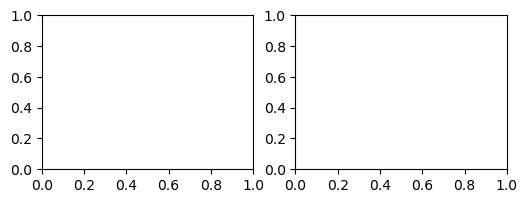

In [215]:
# f, (ax1, ax2) = plt.subplots(1, 2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))

In [216]:
data = patientProps[patientProps.status == "10mix"]
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
# Reorder the categories in adata.obs['leiden_res0_25']
data["cell_type"] = pd.Categorical(
    data["cell_type"], categories=desired_order, ordered=True
)
x = "cell_type"
hue = "cell_type"
palette = [
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:red",
    "tab:purple",
    "tab:green",
    "tab:blue",
    "tab:red",
    "tab:orange",
    "tab:green",
    "tab:green",
]
order = list(
    data.loc[data.status == "10mix", ["percent", "sample_id", "cell_type"]]
    .groupby(by="cell_type")
    .median()
    .sort_values(by="percent", ascending=False)
    .index
)
sns.boxplot(x=y, y=x, data=data, ax=ax1, palette=palette, order=desired_order)
sns.stripplot(
    x=y,
    y=x,
    data=data,
    ax=ax1,
    palette=palette,
    order=desired_order,
    dodge=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
)
ax1.set_ylabel("")
ax1.invert_xaxis()
ax1.set_title("10mix")

/tmp/ipykernel_2985564/2359200896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cell_type"] = pd.Categorical(
/tmp/ipykernel_2985564/2359200896.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order=list(data.loc[data.status=="10mix",["percent","sample_id","cell_type"]].groupby(by="cell_type").median().sort_values(by="percent", ascending=False).index)


Text(0.5, 1.0, '10mix')

In [217]:
data

,counts,percent,sample_id,cell_type,status,statuscell_type,samplelabels
0,3980,0.556410,10mix_ICI1,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix_ICI1
1,3856,0.474118,10mix_ICI2,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix_ICI2
2,3297,0.405385,10mix_ICI2,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix_ICI2
3,1631,0.228016,10mix_ICI1,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix_ICI1
4,1331,0.186076,10mix_ICI1,CD8_EffectorMemory,10mix,10mix_CD8_EffectorMemory,10mix_10mix_ICI1
5,1168,0.529465,10mix1,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix1
6,827,0.511125,10mix2,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix2
7,704,0.086561,10mix_ICI2,CD8_EffectorMemory,10mix,10mix_CD8_EffectorMemory,10mix_10mix_ICI2
8,544,0.246600,10mix1,CD8_EarlyActiv,10mix,10mix_CD8_EarlyActiv,10mix_10mix1
9,494,0.223935,10mix1,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix1


In [218]:
order

['CD8_NaiveLike',
 'CD8_Tex',
 'CD8_EffectorMemory',
 'CD8_EarlyActiv',
 'CD8_Tpex']

In [223]:
data = patientProps[(patientProps.status == "11mix")]
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
x = "cell_type"
hue = "cell_type"
palette = [
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:red",
    "tab:purple",
    "tab:green",
    "tab:blue",
    "tab:red",
    "tab:orange",
    "tab:green",
    "tab:green",
]
order = list(
    data.loc[data.status == "11mix", ["percent", "sample_id", "cell_type"]]
    .groupby(by="cell_type")
    .median()
    .sort_values(by="percent", ascending=False)
    .index
)
sns.boxplot(x=y, y=x, data=data, ax=ax2, palette=palette, order=desired_order)
sns.stripplot(
    x=y,
    y=x,
    data=data,
    ax=ax2,
    palette=palette,
    order=desired_order,
    dodge=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
)
ax2.tick_params(
    axis="y", which="both", left=False, right=True, labelleft=False, labelright=True
)
ax2.set_ylabel("")
ax2.set_title("11mix")

/tmp/ipykernel_2985564/1642101532.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order=list(data.loc[data.status=="11mix",["percent","sample_id","cell_type"]].groupby(by="cell_type").median().sort_values(by="percent", ascending=False).index)


Text(0.5, 1.0, '11mix')

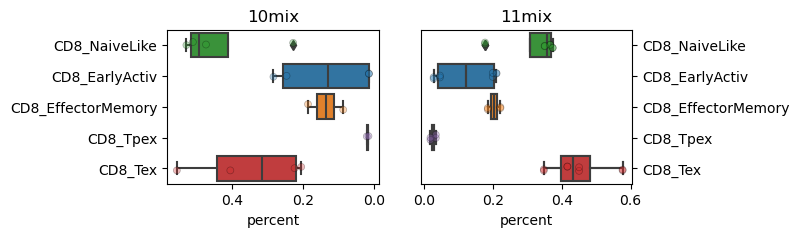

In [224]:
f.savefig(
    fname="./figures/barplots_patient_percents_CD8annotation.png",
    dpi=300,
    bbox_inches="tight",
)
f.savefig(
    fname="./figures/barplots_patient_percents_CD8annotation.svg", bbox_inches="tight"
)
f

In [310]:
import scanpy as sc

# Check if the gene is in adata.var_names
gene_id = "ENSMUSG00000055170"

if gene_id in adata.var_names:
    # Extract the expression values for the gene
    gene_expression = (
        adata[:, gene_id].X.toarray().flatten()
        if hasattr(adata[:, gene_id].X, "toarray")
        else adata[:, gene_id].X.flatten()
    )

    # Filter adata to keep only cells where gene expression > 0
    adata_ifng = adata[gene_expression > 6].copy()

    print(f"New adata created with {adata_ifng.n_obs} cells expressing {gene_id}.")
else:
    print(f"Gene '{gene_id}' not found in adata.var_names")

New adata created with 3369 cells expressing ENSMUSG00000055170.


In [363]:
adata_10 = adata_ifng[
    adata_ifng.obs["sample_id"].isin(["10mix1", "10mix2", "10mix_ICI1", "10mix_ICI2"])
]

In [364]:
adata_11 = adata_ifng[
    adata_ifng.obs["sample_id"].isin(["11mix1", "11mix2", "11mix_ICI1", "11mix_ICI2"])
]

In [365]:
test = pd.DataFrame(adata_10.obs.value_counts(subset=["cell_type", "sample_id"]))
testp = adata_10.obs.value_counts(subset=["sample_id"])
test.columns = ["counts"]
test["percent"] = test.counts
for p in set(adata_10.obs.sample_id):
    test.loc[test.index.get_level_values("sample_id") == p, "percent"] = (
        test.loc[test.index.get_level_values("sample_id") == p, "percent"] / testp[p]
    )
test["percent"] = [float(x) for x in test["percent"]]
test["sample_id"] = [str(x) for x in test.index.get_level_values("sample_id")]
test["cell_type"] = [str(x) for x in test.index.get_level_values("cell_type")]
# test["IFNG+"]=[str(x) for x in test.index.get_level_values("IFNG_0.2")]
test["status"] = "10mix"

In [366]:
patientProps = test

In [367]:
test = pd.DataFrame(adata_11.obs.value_counts(subset=["cell_type", "sample_id"]))
testp = adata_11.obs.value_counts(subset=["sample_id"])
test.columns = ["counts"]
test["percent"] = test.counts
for p in set(adata_11.obs.sample_id):
    test.loc[test.index.get_level_values("sample_id") == p, "percent"] = (
        test.loc[test.index.get_level_values("sample_id") == p, "percent"] / testp[p]
    )
test["percent"] = [float(x) for x in test["percent"]]
test["sample_id"] = [str(x) for x in test.index.get_level_values("sample_id")]
test["cell_type"] = [str(x) for x in test.index.get_level_values("cell_type")]
# test["IFNG+"]=[str(x) for x in test.index.get_level_values("IFNG_0.2")]
test["status"] = "11mix"

In [368]:
patientProps

counts   percent   sample_id  \
cell_type          sample_id                                  
CD8_Tex            10mix_ICI2     539  0.745505  10mix_ICI2   
                   10mix_ICI1     430  0.620491  10mix_ICI1   
CD8_EffectorMemory 10mix_ICI1     176  0.253968  10mix_ICI1   
CD8_EarlyActiv     10mix1         158  0.658333      10mix1   
                   10mix2         131  0.696809      10mix2   
CD8_EffectorMemory 10mix_ICI2     119  0.164592  10mix_ICI2   
CD8_NaiveLike      10mix_ICI1      56  0.080808  10mix_ICI1   
                   10mix1          41  0.170833      10mix1   
CD8_Tex            10mix1          41  0.170833      10mix1   
CD8_Tpex           10mix_ICI2      40  0.055325  10mix_ICI2   
CD8_Tex            10mix2          29  0.154255      10mix2   
CD8_NaiveLike      10mix2          28  0.148936      10mix2   
CD8_Tpex           10mix_ICI1      26  0.037518  10mix_ICI1   
CD8_NaiveLike      10mix_ICI2      15  0.020747  10mix_ICI2   
CD8_EarlyActiv     10mix_ICI2      10  0.013831  10mix_ICI2   
                   10mix_ICI1       5  0.007215  10mix_ICI1   

                                        cell_type status  
cell_type          sample_id                              
CD8_Tex            10mix_ICI2             CD8_Tex  10mix  
                   10mix_ICI1             CD8_Tex  10mix  
CD8_EffectorMemory 10mix_ICI1  CD8_EffectorMemory  10mix  
CD8_EarlyActiv     10mix1          CD8_EarlyActiv  10mix  
                   10mix2          CD8_EarlyActiv  10mix  
CD8_EffectorMemory 10mix_ICI2  CD8_EffectorMemory  10mix  
CD8_NaiveLike      10mix_ICI1       CD8_NaiveLike  10mix  
                   10mix1           CD8_NaiveLike  10mix  
CD8_Tex            10mix1                 CD8_Tex  10mix  
CD8_Tpex           10mix_ICI2            CD8_Tpex  10mix  
CD8_Tex            10mix2                 CD8_Tex  10mix  
CD8_NaiveLike      10mix2           CD8_NaiveLike  10mix  
CD8_Tpex           10mix_ICI1            CD8_Tpex  10mix  
CD8_NaiveLike      10mix_ICI2       CD8_NaiveLike  10mix  
CD8_EarlyActiv     10mix_ICI2      CD8_EarlyActiv  10mix  
                   10mix_ICI1      CD8_EarlyActiv  10mix

In [369]:
patientProps = pd.concat([patientProps, test], ignore_index=True, axis=0, join="outer")
patientProps["statuscell_type"] = patientProps.status + "_" + patientProps.cell_type
patientProps["samplelabels"] = patientProps.status + "_" + patientProps.sample_id
# patientProps["IFNG+"].replace(to_replace="True", value="Pos", inplace=True)
# patientProps["IFNG+"].replace(to_replace="False", value="Neg", inplace=True)
# patientProps["x"]="x"

In [370]:
# hueord=['CD4_MSI','CD4_MSS','CD8_MSI','CD8_MSS','undefined_MSI','undefined_MSS','CD4_NormMSI','CD4_NormMSS','CD8_NormMSI','CD8_NormMSS','undefined_NormMSI','undefined_NormMSS']
x = "cell_type"
y = "percent"
hue = "status"
data = patientProps

In [371]:
from scipy.special import logit

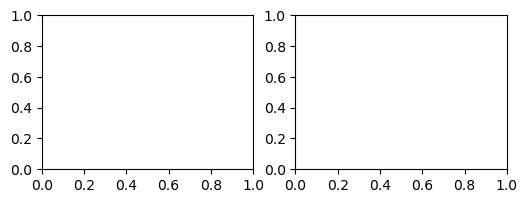

In [402]:
# f, (ax1, ax2) = plt.subplots(1, 2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))

In [403]:
import numpy as np

In [404]:
data = patientProps[patientProps.status == "10mix"]
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
# Reorder the categories in adata.obs['leiden_res0_25']
data["cell_type"] = pd.Categorical(
    data["cell_type"], categories=desired_order, ordered=True
)
x = "cell_type"
hue = "cell_type"
palette = [
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:red",
    "tab:purple",
    "tab:green",
    "tab:blue",
    "tab:red",
    "tab:orange",
    "tab:green",
    "tab:green",
]
order = list(
    data.loc[data.status == "10mix", ["percent", "sample_id", "cell_type"]]
    .groupby(by="cell_type")
    .median()
    .sort_values(by="percent", ascending=False)
    .index
)
sns.boxplot(x=y, y=x, data=data, ax=ax1, palette=palette, order=desired_order)
sns.stripplot(
    x=y,
    y=x,
    data=data,
    ax=ax1,
    palette=palette,
    order=desired_order,
    dodge=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
)
ax1.set_ylabel("")
ax1.set_xlabel("Fraction of cells")
ax1.invert_xaxis()
ax1.set_title("10mix")

/tmp/ipykernel_2985564/1473218847.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cell_type"] = pd.Categorical(
/tmp/ipykernel_2985564/1473218847.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order=list(data.loc[data.status=="10mix",["percent","sample_id","cell_type"]].groupby(by="cell_type").median().sort_values(by="percent", ascending=False).index)


Text(0.5, 1.0, '10mix')

In [405]:
data

,counts,percent,sample_id,cell_type,status,statuscell_type,samplelabels
0,539,0.745505,10mix_ICI2,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix_ICI2
1,430,0.620491,10mix_ICI1,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix_ICI1
2,176,0.253968,10mix_ICI1,CD8_EffectorMemory,10mix,10mix_CD8_EffectorMemory,10mix_10mix_ICI1
3,158,0.658333,10mix1,CD8_EarlyActiv,10mix,10mix_CD8_EarlyActiv,10mix_10mix1
4,131,0.696809,10mix2,CD8_EarlyActiv,10mix,10mix_CD8_EarlyActiv,10mix_10mix2
5,119,0.164592,10mix_ICI2,CD8_EffectorMemory,10mix,10mix_CD8_EffectorMemory,10mix_10mix_ICI2
6,56,0.080808,10mix_ICI1,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix_ICI1
7,41,0.170833,10mix1,CD8_NaiveLike,10mix,10mix_CD8_NaiveLike,10mix_10mix1
8,41,0.170833,10mix1,CD8_Tex,10mix,10mix_CD8_Tex,10mix_10mix1
9,40,0.055325,10mix_ICI2,CD8_Tpex,10mix,10mix_CD8_Tpex,10mix_10mix_ICI2


In [406]:
order

['CD8_Tex',
 'CD8_EarlyActiv',
 'CD8_EffectorMemory',
 'CD8_NaiveLike',
 'CD8_Tpex']

In [407]:
data = patientProps[(patientProps.status == "11mix")]
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
x = "cell_type"
hue = "cell_type"
palette = [
    "tab:green",
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:red",
    "tab:purple",
    "tab:green",
    "tab:blue",
    "tab:red",
    "tab:orange",
    "tab:green",
    "tab:green",
]
order = list(
    data.loc[data.status == "11mix", ["percent", "sample_id", "cell_type"]]
    .groupby(by="cell_type")
    .median()
    .sort_values(by="percent", ascending=False)
    .index
)
sns.boxplot(x=y, y=x, data=data, ax=ax2, palette=palette, order=desired_order)
sns.stripplot(
    x=y,
    y=x,
    data=data,
    ax=ax2,
    palette=palette,
    order=desired_order,
    dodge=True,
    alpha=0.3,
    edgecolor="black",
    linewidth=0.5,
)
ax2.tick_params(
    axis="y", which="both", left=False, right=True, labelleft=False, labelright=True
)
ax2.set_ylabel("")
ax2.set_xlabel("Fraction of cells")
# ax2.invert_xaxis()
ax2.set_title("11mix")

/tmp/ipykernel_2985564/969055098.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order=list(data.loc[data.status=="11mix",["percent","sample_id","cell_type"]].groupby(by="cell_type").median().sort_values(by="percent", ascending=False).index)


Text(0.5, 1.0, '11mix')

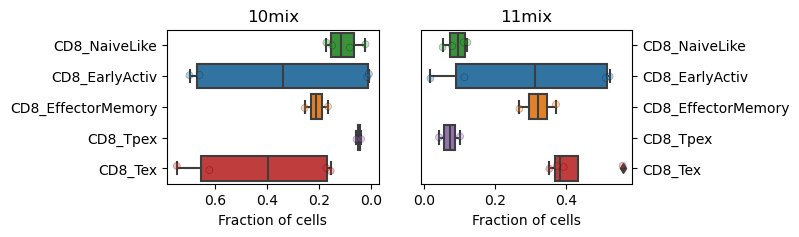

In [408]:
f.savefig(
    fname="./figures/barplots_patient_percents_CD8annotation.png",
    dpi=300,
    bbox_inches="tight",
)
f.savefig(
    fname="./figures/barplots_patient_percents_CD8annotation.svg", bbox_inches="tight"
)
f

In [385]:
# Specify the desired order of the categories
desired_order = [
    "CD8_NaiveLike",
    "CD8_EarlyActiv",
    "CD8_EffectorMemory",
    "CD8_Tpex",
    "CD8_Tex",
]
# Reorder the categories in adata.obs['leiden_res0_25']
adata_ifng.obs["cell_type"] = pd.Categorical(
    adata_ifng.obs["cell_type"], categories=desired_order, ordered=True
)

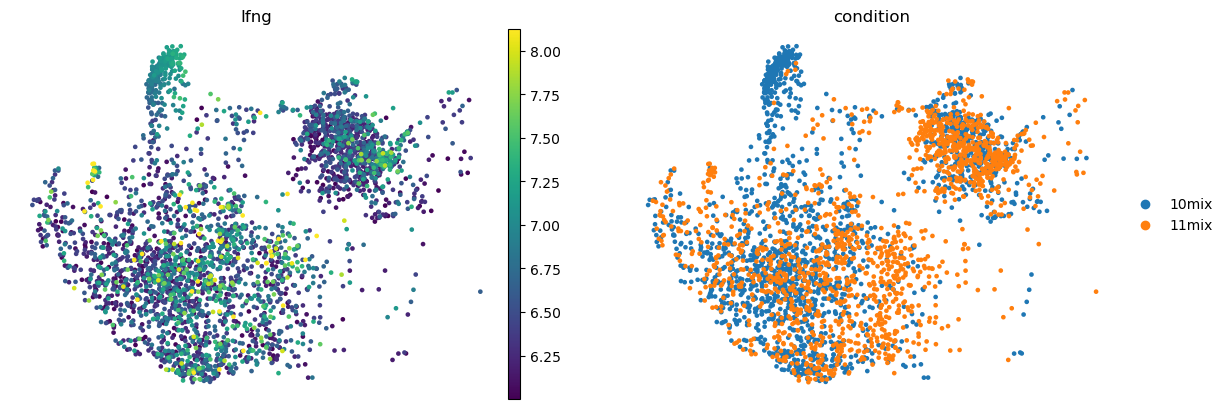

In [390]:
# Visualize
custom_colors = [
    "#3A923A",
    "#146aff",
    "#ff8113",
    "#fff314",
    "#D8393A",
]  # Example colors

# Add these colors to the `adata_og.uns` dictionary for the `cell_type` category
adata_ifng.uns["cell_type_colors"] = custom_colors

sc.pl.umap(
    adata_ifng,
    color=["ENSMUSG00000055170", "condition"],
    frameon=False,
    vmax="p99",
    cmap="viridis",
    title="Ifng",
    size=45,
    save="ifng_bigger6.png",
)

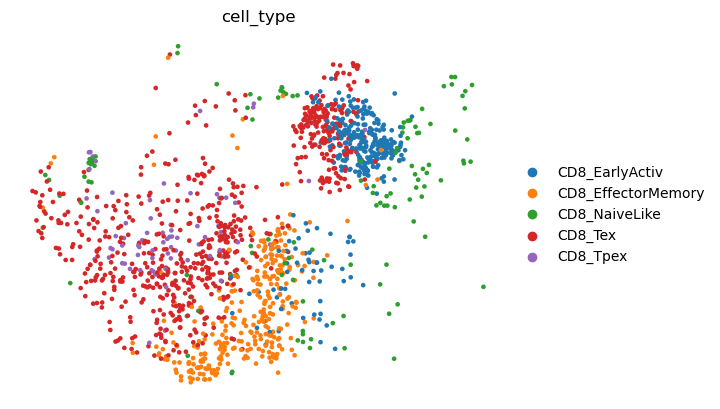

In [380]:
sc.pl.umap(adata_11, color="cell_type", frameon=False, size=45)

In [331]:
adata_10

AnnData object with n_obs × n_vars = 1844 × 11945
    obs: '_scvi_batch', '_scvi_labels', 'batch', 'batch_id', 'cell_type', 'condition', 'is_doublet', 'is_outlier', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_mito', 'is_outlier_top_20', 'leiden', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'n_counts', 'n_genes', 'n_genes_by_counts', 'origin', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'sample_id', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'value', 'outlier', 'mt_outlier', 'ribo_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'functional.cluster', 'Ifng_expression', 'ifng'
    var: 'ensembl_id', 'feature_types', 'gene_name', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_varia

In [332]:
adata_11

View of AnnData object with n_obs × n_vars = 1525 × 11945
    obs: '_scvi_batch', '_scvi_labels', 'batch', 'batch_id', 'cell_type', 'condition', 'is_doublet', 'is_outlier', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_mito', 'is_outlier_top_20', 'leiden', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'n_counts', 'n_genes', 'n_genes_by_counts', 'origin', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'sample_id', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'value', 'outlier', 'mt_outlier', 'ribo_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'functional.cluster', 'Ifng_expression', 'ifng'
    var: 'ensembl_id', 'feature_types', 'gene_name', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'high

In [342]:
adata_ifng

AnnData object with n_obs × n_vars = 3369 × 11945
    obs: '_scvi_batch', '_scvi_labels', 'batch', 'batch_id', 'cell_type', 'condition', 'is_doublet', 'is_outlier', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_mito', 'is_outlier_top_20', 'leiden', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'log1p_total_counts_ribo', 'n_counts', 'n_genes', 'n_genes_by_counts', 'origin', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'sample_id', 'total_counts', 'total_counts_mt', 'total_counts_ribo', 'value', 'outlier', 'mt_outlier', 'ribo_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'functional.cluster', 'Ifng_expression', 'ifng'
    var: 'ensembl_id', 'feature_types', 'gene_name', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_varia